In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

In [2]:
class PINNv3(nn.Module):
    def __init__(self, inp_size, out_size) -> None:
        super().__init__()
        self.layer1 = nn.Linear(inp_size, 128)
        self.norm1 = nn.LayerNorm(128)
        self.layer2 = nn.Linear(128, 64)
        self.norm2 = nn.LayerNorm(64)
        self.layer3 = nn.Linear(64, out_size)

    def forward(self, x):
        x = F.tanh(self.norm1(self.layer1(x)))
        x = F.tanh(self.norm2(self.layer2(x)))

        return self.layer3(x)

In [3]:
def get_pos(v:float, theta:float, t:float):
    """This Return the (x,y) cord for the given projectile parameter.

    Args:
        v (float): velocity in m/s^2
        theta (float): angle of  projectile in radian
        t (float): time in second

    Returns:
        x, y
    """
    x = v*np.cos(theta)*t
    y = -0.5*9.8*t**2 + v*np.sin(theta)*t

    return x, y

In [4]:
def get_timeOfFlight(v0:float, theta:float):
    """_summary_

    Args:
        v0 (float): velocity m/s^2
        theta (float): angle in rad

    Returns:
        T (float): time of flight
    """
    g = 9.8
    T = 2*(v0*np.sin(theta))/g
    
    return T

In [5]:
SCALE_FACTOR = 100

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = PINNv3(3,2)


In [8]:
model.load_state_dict(torch.load("checkpoint/PINNv3_model_ep10000_1722108340.pt"))

<All keys matched successfully>

In [9]:
model.to(device)

PINNv3(
  (layer1): Linear(in_features=3, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer3): Linear(in_features=64, out_features=2, bias=True)
)

In [10]:
model.eval()
with torch.no_grad():
    v, alpha, t = 30, 70, 2
    alpha= np.deg2rad(alpha)
    validation_sample = torch.tensor([v/100, alpha, t/100], dtype=torch.float)
    pred_y = model(validation_sample.to(device))*SCALE_FACTOR
    val_y = get_pos(v, alpha, t)
    print("Input", validation_sample, "\nOutput", pred_y, "\nTruth", val_y)

Input tensor([0.3000, 1.2217, 0.0200]) 
Output tensor([18.8103, 35.5056], device='cuda:0') 
Truth (20.52120859954013, 36.781557247154495)


In [11]:
def get_validation(model, v, alpha):
    theory = {
        "x":[],
        "y":[]
    }
    predicted = {
        "x":[],
        "y":[]
    }

    model.eval()
    with torch.no_grad():
        # v = 30
        # alpha = 45
        alpha = np.deg2rad(alpha)
        v_s = v/SCALE_FACTOR
        T = get_timeOfFlight(v, alpha)
        print(T)
        
        for t in np.arange(0,T+1, 0.001):
            if t >=T:
                break
            t_s = t/SCALE_FACTOR
            inp = torch.tensor([v_s, alpha, t_s], dtype=torch.float)
            pred = model(inp.to(device))*SCALE_FACTOR
        
            x, y = get_pos(v, alpha, t)
            theory["x"].append(x)
            theory["y"].append(y)

            predicted["x"].append(pred[0].item())
            predicted["y"].append(pred[1].item())
        
    return theory, predicted


In [12]:
import matplotlib.pyplot as plt

In [13]:
theory1, predicted1 = get_validation(model=model, v=45, alpha=60)

7.953294524550967


In [14]:
theory2, predicted2 = get_validation(model=model, v=55, alpha=45)

7.936912850053083


In [15]:
theory3, predicted3 = get_validation(model=model, v=60, alpha=30)

6.1224489795918355


In [16]:
theory4, predicted4 = get_validation(model=model, v=85, alpha=20)

5.933002486261599


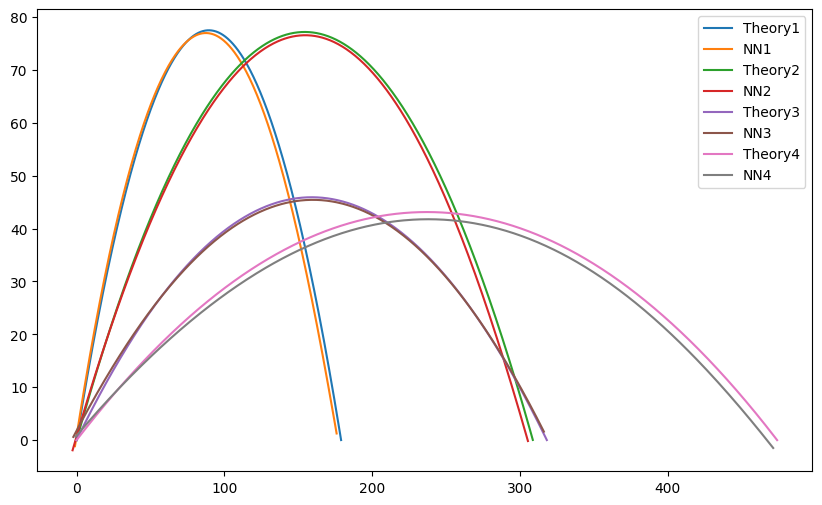

In [17]:
plt.figure(figsize=(10,6))
plt.plot(theory1["x"], theory1["y"])
plt.plot(predicted1["x"], predicted1["y"])

plt.plot(theory2["x"], theory2["y"])
plt.plot(predicted2["x"], predicted2["y"])

plt.plot(theory3["x"], theory3["y"])
plt.plot(predicted3["x"], predicted3["y"])

plt.plot(theory4["x"], theory4["y"])
plt.plot(predicted4["x"], predicted4["y"])

plt.legend(["Theory1", "NN1", "Theory2", "NN2", "Theory3", "NN3", "Theory4", "NN4"])